In [23]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import random

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.10.0


In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = 'C:/Users/82108/Desktop/2023boot/python/'
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [600, 600]
EPOCHS = 25

In [25]:
model = load_model('factory_model_fi2.h5')

In [26]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 600, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 600, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 300, 16)     0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 150, 150, 32)      2160      
                                                                 
 sequential_1 (Sequential)   (None, 75, 75, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 37, 37, 128)       27072     
                                                      

In [27]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "NG"

In [28]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [29]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [30]:
# classify_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/Facotry/test2/*'))
# classify_IMAGE_COUNT = tf.data.experimental.cardinality(classify_list_ds).numpy()
# classify_ds = classify_list_ds.map(process_path, num_parallel_calls=None)
# classify_ds = classify_ds.batch(BATCH_SIZE)
# classify_ds = classify_ds.shuffle(buffer_size=1, reshuffle_each_iteration=False)

# classify_IMAGE_COUNT

In [31]:
# 이미지 파일 경로를 로드하여 리스트로 저장합니다.
file_paths = tf.data.Dataset.list_files(str(GCS_PATH + '/Facotry/test2/*')).as_numpy_iterator()
file_paths = list(file_paths)

# 파일 경로들을 미리 정렬합니다.
random.shuffle(file_paths)
file_paths_ds = tf.data.Dataset.from_tensor_slices(file_paths)

# 정렬된 파일 경로들을 이용하여 데이터셋을 구성합니다.
classify_ds = file_paths_ds.map(process_path, num_parallel_calls=None)
classify_ds = classify_ds.batch(BATCH_SIZE)

classify_IMAGE_COUNT = tf.data.experimental.cardinality(file_paths_ds).numpy()

classify_IMAGE_COUNT

10

In [32]:
classify_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>

In [33]:
model.predict(classify_ds)

2/2 [==============================] - 3s 3s/step


array([[0.10522845],
       [0.30352518],
       [0.05146113],
       [0.03604236],
       [0.25150198],
       [0.12482253],
       [0.4622063 ],
       [0.5486436 ],
       [0.9212712 ],
       [0.02190507]], dtype=float32)

In [34]:
prediction = model.predict(classify_ds)

2/2 [==============================] - 0s 114ms/step


In [35]:
prediction[0]

array([0.10522845], dtype=float32)

In [36]:
prediction[0] > 0.7

array([False])

In [37]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/Facotry/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

47

In [38]:
loss, acc, prec, rec = model.evaluate(test_ds)

6/6 [==============================] - 2s 133ms/step - loss: 0.2270 - accuracy: 0.8936 - precision: 0.8824 - recall: 0.8333


In [39]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(classify_IMAGE_COUNT):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if prediction[n]>0.3:
            plt.title("NG")
        else:
            plt.title("OK")
        plt.axis("off")

In [43]:
def show_batch(image_batch, prediction):
    plt.figure(figsize=(10, 10))
    batch_size = len(image_batch)
    for n in range(batch_size):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(image_batch[n])
        if prediction[n] > 0.3:
            plt.title("NG")
        else:
            plt.title("OK")
        plt.axis("off")

In [44]:
image_batch, label_batch = next(iter(classify_ds))

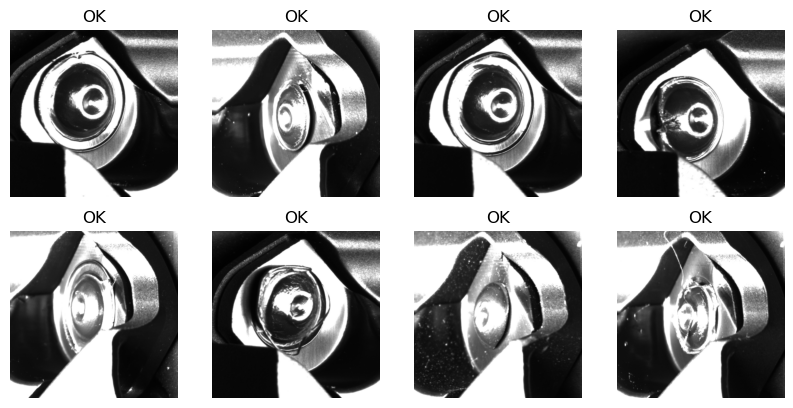

In [45]:
show_batch(image_batch.numpy(), label_batch.numpy())

1/1 [==============================] - 0s 39ms/step


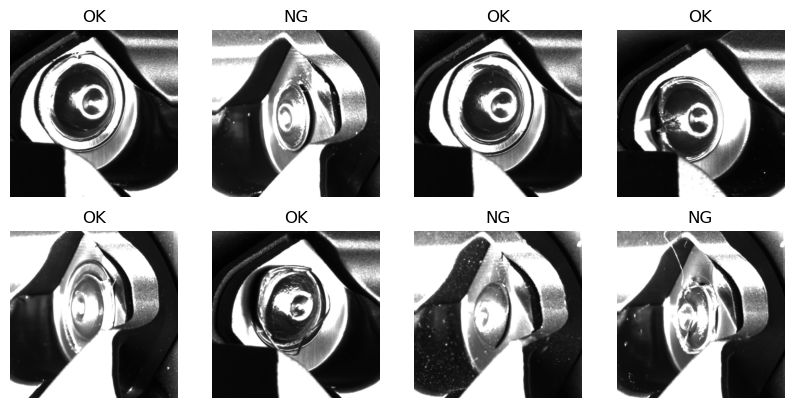

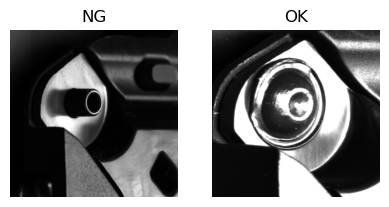

In [47]:
def show_all_batches(classify_ds, model):
    for image_batch, _ in classify_ds:
        prediction = model.predict(image_batch)
        show_batch(image_batch.numpy(), prediction)

show_all_batches(classify_ds, model)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 9 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

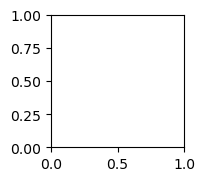

In [42]:
plt.figure(figsize=(10,10))
ax = plt.subplot(5,5,1)
plt.imshow(image_batch[1])
plt.axis("off")